# Question 1

Description of approach: We will use the read_table function in pandas to read the textfile and turn the textfile into a dataframe, splitting on the whitespace, and then renaming the columns.

In [91]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [92]:
datagold = pd.read_table("gold.txt", delim_whitespace=True, header=None, names = ['URL','CATEGORY'])
datalabel = pd.read_table("labels.txt", delim_whitespace=True, header=None, names=['TURK', 'URL', 'CATEGORY'])

# Question 2

Description of approach: We will create two masks to apply to the label data frame. The first mask wil make a newdataframe with all the Url's that are in gold and label. The second mask will do the opposite of this, and create a dataframe where the URL's are unique to the label dataframe only.

In [93]:
labels_on_gold_mask = datalabel['URL'].isin(datagold['URL'])
labels_unknown_mask = ~datalabel['URL'].isin(datagold['URL'])
labels_on_gold= datalabel[labels_on_gold_mask]
labels_unknown= datalabel[labels_unknown_mask]

# Question 3

Description of approach: First we will make a copy of labels_on_gold dataframe, then we merge this data set with the datagold dataset on URL so that we can get the actual category rating's for each URL. We will create a new column called CORRECT for this dataframe that gives a 1 if the turk rated the url correctly and a 0 if it did not. Then we create a pivot table using this new dataframe created, with the index being 'TURK' and summing the number of correct cnts per each 'TURK'. We will then create a dataframe that holds the total times a turk rated a url. We merge this dataframe with the pivot table on the index='TURK'. Finally, we compute the average correctness of a turk by diving the sum of corrects per turk by the total times a turk rated something and save this as rater_goodness.

In [94]:
import numpy as np

#create a copy to manipulate
labels_on_gold_copy = labels_on_gold.copy()

#merge the dataframes so we can get the turks response and the actual response
merged = labels_on_gold_copy.merge(datagold, left_on='URL', right_on='URL')
merged.columns = ['TURK', 'URL', 'TURK RTING', 'ACTUAL RATING']

#create a column that is 1 for correct and 0 for not correct int he url rating
merged['CORRECT'] = np.where(merged['TURK RTING'] == merged['ACTUAL RATING'], 1, 0)

#create a table to sum of the times correct per each turk
correct_pivot = pd.pivot_table(merged, index='TURK', columns=None, values='CORRECT', aggfunc='sum')

# create a dataframe that counts the total number of times a turk rated a gold url
turkcnt = merged['TURK'].value_counts().to_frame()
turkcnt.columns = ['TOTALCNT']

#merge these two df on the index
pre_rater_goodness = turkcnt.merge(correct_pivot, left_index=True, right_index=True)

#compute the average times the are correct (correct times/total times)
pre_rater_goodness['AVERAGE CORRECT'] = pre_rater_goodness['CORRECT']/pre_rater_goodness['TOTALCNT']
rater_goodness = pre_rater_goodness[['TOTALCNT', 'AVERAGE CORRECT']]
rater_goodness[:20]

,TOTALCNT,AVERAGE CORRECT
A31OCN4MNHUQ6W,184,0.777174
A153PKAL7OAY36,148,0.722973
A2BTR0GQ5B5JI6,126,0.523810
ATVALOQVDCMZW,103,0.854369
AZSDW7JJL5VA7,100,0.680000
A3GE97GX3OXJTW,85,0.658824
A2JP3HEL3J25AJ,80,0.687500
A3JMQDTEKRE5X6,80,0.675000
A3MA9V9UPGCOK7,71,0.774648
APYV9Y0DFZFVP,71,0.746479


# Question 4

Description of approach: We created a new column called 'ODDS' that will use the formula p/(1.001-p) with p being the fraction from Q.3 above in the 'AVERAGE CORRECT' column.

In [95]:
rater_goodness['ODDS']= (rater_goodness['AVERAGE CORRECT']/(1.001-rater_goodness['AVERAGE CORRECT']))
rater_goodness[:20]

,TOTALCNT,AVERAGE CORRECT,ODDS
A31OCN4MNHUQ6W,184,0.777174,3.472222
A153PKAL7OAY36,148,0.722973,2.600369
A2BTR0GQ5B5JI6,126,0.523810,1.097695
ATVALOQVDCMZW,103,0.854369,5.826657
AZSDW7JJL5VA7,100,0.680000,2.118380
A3GE97GX3OXJTW,85,0.658824,1.925391
A2JP3HEL3J25AJ,80,0.687500,2.192982
A3JMQDTEKRE5X6,80,0.675000,2.070552
A3MA9V9UPGCOK7,71,0.774648,3.422313
APYV9Y0DFZFVP,71,0.746479,2.932876


# Question 5

Description of approach: Create a mask to only have turks who have rated at least 20 gold set URLS. Make a new dataframe using this mask and then sort this dataframe by the 'ODDS' column in descending order, and only show the top 10!

In [96]:
mask20 = (rater_goodness['TOTALCNT']>=20)
cnt20raters = rater_goodness[mask20]
cnt20raters.sort_values('ODDS', ascending=False)[:10]

,TOTALCNT,AVERAGE CORRECT,ODDS
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A20PWAB7G3HDHU,20,0.800000,3.980100
A32W20KGQXS0LL,25,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635
A31OCN4MNHUQ6W,184,0.777174,3.472222


# Question 6

Description of Approach: We ran a correlation on the total cnt number vs their average correct to see if their is a relationship between the two variables. If it returns a very small value for the correlation then we can assume that there is no relationship. We also tried a spearman regression to make sure there was no other type of relationship and plotted the values to make sure there was no pattern.

ANSWER: So with a simple correlation you can see that there is no linear relationship or correlation. The value is very low. The same goes for a seaman regression, and you can see from the plot there is really no pattern.


Simple correlation:  0.0452923828048
Spearman correlation:  -0.0819193561196


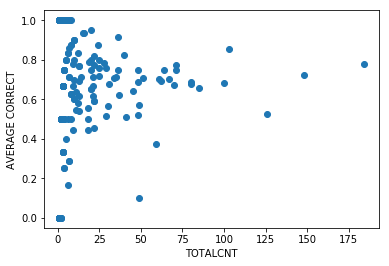

In [97]:
print "Simple correlation: ",rater_goodness['TOTALCNT'].corr(rater_goodness['AVERAGE CORRECT'])
print "Spearman correlation: ",rater_goodness['TOTALCNT'].corr(rater_goodness['AVERAGE CORRECT'], method='spearman')
plot(rater_goodness['TOTALCNT'], rater_goodness['AVERAGE CORRECT'], marker='o', linestyle='None')
xlabel('TOTALCNT')
ylabel('AVERAGE CORRECT')

# Question 7

Description of approach: First we created a dataframe using a mask of the top 75 and above quartile for total count of raters who rated gold urls. Then we merged this dataframe with the labels_unknown dataframe to get the odds for all the labels_unkown turks! Finally, we created a pivot table that uses URL as the index and each column will be the rating category (i.e. G, P, X, R) and each cell will contain the product of all the odds for that specific url and category. 

In [107]:
min_gold_count = rater_goodness['TOTALCNT'].quantile(.75)
rater_goodness_75= rater_goodness[rater_goodness['TOTALCNT']>=min_gold_count]
rater_goodness_75 =rater_goodness_75.reset_index(level=0)
rater_goodness_75.columns = ['TURK', 'TOTALCNT', 'AVERAGE CORRECT','ODDS']



#create a new dataframe that has URL CATEGORY and a space to hold the odds
labels_unknown_copy= labels_unknown.copy()

finalmergeddf = labels_unknown_copy.merge(rater_goodness_75, on='TURK', how='right')
finalpivot = pd.pivot_table(finalmergeddf, index='URL', columns='CATEGORY',values='ODDS', aggfunc='prod')
finalpivot[:20]

CATEGORY,G,P,R,X
URL,,,,
http://0-101.net,2.155963,NaN,NaN,NaN
http://000.cc,1.460583,NaN,NaN,NaN
http://0000.jp,14.488244,NaN,NaN,NaN
http://000relationships.com,9.914590,1.851852,NaN,NaN
http://000vitamins.com,3.784982,NaN,NaN,NaN
http://000webhost.com,11.159502,NaN,NaN,NaN
http://003my.com,4.912040,NaN,NaN,NaN
http://007absolutehardcore.com/early_cumshots/index.html,NaN,3.346522,12.290450,293.252871
http://007swz.cn,1.393883,NaN,NaN,NaN


# Question 8

Description of approach: We created a dataframe with the top category and top odds for each url. We did this by using the transpose of the pivot table and implementing the idxmax function to grab the index name of the largest odds value and then the max function to grab the actual largest odds value for each URL.

In [103]:
# find the category max for each url
categorydf = finalpivot.T.idxmax().to_frame()
# find the odds max with that category for each url
oddsdf = finalpivot.T.max().to_frame()

#merge these two dataframes to create one dataframe with top category and mathcing odds
result75 = categorydf.merge(oddsdf, how='inner', left_index=True, right_index=True)
result75.columns = ['TOP CATEGORY75', 'TOP ODDS75']
result75[:20]


,TOP CATEGORY75,TOP ODDS75
URL,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,9.914590
http://000vitamins.com,G,3.784982
http://000webhost.com,G,11.159502
http://003my.com,G,4.912040
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.393883


# Question 9


Description of approach: First we created a dataframe using a mask of the top 25 and above quartile for the totalcount of raters who rated gold urls. Then we merged this dataframe with the labels_unknown dataframe to get the odds for all the labels_unkown turks! Next, we made a pivot table that uses URL as the index and each column represents the rating category (i.e. G, P, X, R) while each cell contains the product of all the odds for that specific url and category. Then we used the idxmax and the max function to create a dataframe with the top category and top odds for each url.(Same as we did for question 7 and 8)

Finally, we use the crosstab function with our final dataframe in Question 9 and our final dataframe in Question 8 to calculate the classification mistakes using the different approaches (i.e. quantile as 75% or quantile as 25%).

ANSWER: Using quartile=.75 had more accuracy than using quartile=.25. You can find the missclassfication rates for quartile=.25 below.


In [108]:
min_gold_count_25 = rater_goodness['TOTALCNT'].quantile(.25)
rater_goodness_25= rater_goodness[rater_goodness['TOTALCNT']>=min_gold_count_25]
rater_goodness_25 =rater_goodness_25.reset_index(level=0)
rater_goodness_25.columns = ['TURK', 'TOTALCNT', 'AVERAGE CORRECT','ODDS']



#create a new dataframe that has URL CATEGORY and a space to hold the odds
labels_unknown_copy_1= labels_unknown.copy()

finalmergeddf25 = labels_unknown_copy_1.merge(rater_goodness_25, on='TURK', how='right')
finalpivot25 = pd.pivot_table(finalmergeddf25, index='URL', columns='CATEGORY',values='ODDS', aggfunc='prod')
finalpivot25[:20]

# find the category max for each url
categorydf25 = finalpivot25.T.idxmax().to_frame()
# find the odds max with that category for each url
oddsdf25 = finalpivot25.T.max().to_frame()

#merge these two dataframes to create one dataframe with top category and mathcing odds
result25 = categorydf25.merge(oddsdf25, how='inner', left_index=True, right_index=True)
result25.columns = ['TOP CATEGORY25', 'TOP ODDS25']
result25[:20]


,TOP CATEGORY25,TOP ODDS25
URL,,
http://0-101.net,G,2.155963e+00
http://000.cc,G,2.181050e+03
http://0000.jp,G,2.877556e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.014149e+03
http://000webhost.com,G,1.113723e+13
http://003my.com,G,4.912040e+00
http://007absolutehardcore.com/early_cumshots/index.html,X,5.847515e+02
http://007swz.cn,G,1.391101e+00


In [109]:
#comparing result 25 and result 75
comparecross = pd.crosstab(result75['TOP CATEGORY75'], result25['TOP CATEGORY25'])
comparecross

TOP CATEGORY25,G,P,R,X
TOP CATEGORY75,,,,
G,7911,836,285,237
P,228,264,65,25
R,22,36,120,35
X,70,12,35,429


Classification Mistakes using 25 and above quartile:
1. Class G 14.65%
2. Class P 54.64%
3. Class R 43.66%
4. Class X 21.43%